# FordA Time‑Series Classification with 1‑D CNN
This notebook demonstrates how to classify the FordA engine‑sound dataset from the UCR/UEA archive using a simple 1‑D Convolutional Neural Network (CNN) implemented with **TensorFlow 2.x** and **Keras**.

## 1. Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds, pkg_resources
import numpy as np, pathlib, zipfile, urllib, matplotlib.pyplot as plt, re
from urllib.error import HTTPError, URLError

print("tfds  :", tfds.__version__)
print("nightly installed?:", 'tfds-nightly' in {p.key for p in pkg_resources.working_set})

2025-04-29 03:22:04.455305: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 03:22:04.455803: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 03:22:04.459718: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 03:22:04.468152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745896924.480279   30411 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745896924.48

tfds  : 4.9.8+nightly
nightly installed?: True


## 2. Load the FordA dataset

In [2]:
def manual_load_ford_a():
    mirrors  = ["https://www.timeseriesclassification.com/aeon-toolkit/FordA.zip"]
    data_dir = pathlib.Path("data/forda_raw")         # 기준 폴더
    data_dir.mkdir(exist_ok=True)

    # Check file existence
    has_train = bool(list(data_dir.glob("**/FordA_TRAIN.ts")))
    has_test  = bool(list(data_dir.glob("**/FordA_TEST.ts")))
    need_dl   = not (has_train and has_test)

    if need_dl:
        zip_path = data_dir / "FordA.zip"
        for url in mirrors:
            try:
                print(f"Downloading {url}")
                req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
                with urllib.request.urlopen(req) as resp, open(zip_path, "wb") as f:
                    f.write(resp.read())
                print("     ↳ done")
                break
            except (HTTPError, URLError) as e:
                print("     ↳ failed:", e)
        else:
            raise RuntimeError("All mirrors failed.")

        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(data_dir)
        zip_path.unlink()               # ZIP 삭제

    # .ts file loader 
    def _load(split):                   # split = "TRAIN" / "TEST"
        path = list(data_dir.glob(f"**/FordA_{split}.ts"))[0]
        print("Reading", path)
        series, labels = [], []
        with open(path) as f:
            for line in f:
                line = line.strip()
                if not line or line[0] in ("@", "#"):
                    continue
                ts, lab = line.split(":")
                series.append([float(v) for v in ts.split(",")])
                labels.append(int(lab))
        X = np.array(series, dtype=np.float32)
        y = ((np.array(labels) + 1) // 2).astype(np.float32)  # {-1,1}→{0,1}
        return X, y

    x_tr, y_tr = _load("TRAIN")
    x_te, y_te = _load("TEST")
    return x_tr, y_tr, x_te, y_te


# Load the dataset
x_train, y_train, x_test, y_test = manual_load_ford_a()
print("Shapes:", x_train.shape, y_train.shape)


Reading data/forda_raw/FordA_TRAIN.ts
Reading data/forda_raw/FordA_TEST.ts
Shapes: (3601, 500) (3601,)


## 2.1 FordA dataset visualization

TRAIN: (3601, 500) (3601,)
TEST : (1320, 500) (1320,)


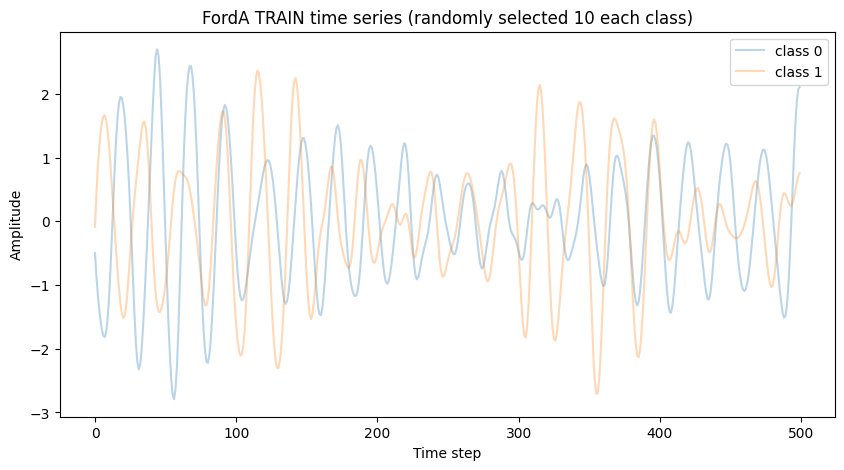

In [ ]:
# 1. data loading
data_dir = pathlib.Path("data/forda_raw")          # .ts 파일 폴더

def _load(split: str):
    X, y = [], []
    with open(data_dir / f"FordA_{split}.ts", encoding="utf-8") as f:
        in_data = False
        for ln in f:
            ln = ln.strip()
            if not ln:                       # empty line
                continue
            if ln.startswith("@data"):       # data start
                in_data = True
                continue
            if not in_data or ln.startswith("@"):
                continue                     # until header

            # 1) 콜론 구분형 ─ "v1,v2,…:label"
            if ":" in ln:
                series_txt, lab_txt = ln.split(":")
                xs  = [float(v) for v in series_txt.split(",") if v]
                lab = int(lab_txt)
            else:
                parts = [p for p in ln.split(",") if p]
                # 2-1) 레이블이 맨 앞이면 parts[0] ∈ {-1,1}
                if re.fullmatch(r"-?1", parts[0]):
                    lab = int(parts[0])
                    xs  = list(map(float, parts[1:]))
                # 2-2) 그렇지 않으면 레이블이 맨 뒤
                else:
                    lab = int(parts[-1])
                    xs  = list(map(float, parts[:-1]))

            X.append(xs)
            y.append((lab + 1) // 2)         # {-1,1} → {0,1}

    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.int32)

    # check safety : FordA time series length= 500
    assert X.shape[1] == 500, f"길이 확인 필요: {X.shape}"
    return X, y

# test : load the dataset
X_train, y_train = _load("TRAIN")
print("TRAIN:", X_train.shape, y_train.shape)   # (3601, 500) (3601,)

X_test,  y_test  = _load("TEST")
print("TEST :", X_test.shape,  y_test.shape)    # (1320, 500) (1320,)



# 2. visualization, randomly selected 1 each class
plt.figure(figsize=(10, 5))
for cls in (0, 1):
    idx = np.where(y_train == cls)[0]
    sel = np.random.choice(idx, 1, replace=False)
    for i in sel:
        plt.plot(X_train[i], alpha=0.3 if cls == 0 else 0.3, 
                 label=f"class {cls}" if i == sel[0] else "")
plt.title("FordA TRAIN time series (randomly selected 1 each class)")
plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


## 3. Normalise signals and expand channel dimension

In [12]:

mean, std = x_train.mean(), x_train.std()

x_train = ((x_train - mean) / std)[..., np.newaxis]  # (N, 500, 1)
x_test  = ((x_test  - mean) / std)[..., np.newaxis]

# Map labels {-1, 1} to {0, 1}
y_train = ((y_train + 1) // 2).astype('float32')
y_test  = ((y_test  + 1) // 2).astype('float32')


## 4. Build the CNN model

In [27]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 5, activation='relu', input_shape=(500, 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 496, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 244, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 244, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,793 (194.50 KB)

 Trainable params: 49,793 (194.50 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train

In [28]:

history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2
)


Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5157 - loss: 0.6910 - val_accuracy: 0.6630 - val_loss: 0.6840
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6617 - loss: 0.6757 - val_accuracy: 0.5201 - val_loss: 0.6525
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5804 - loss: 0.6384 - val_accuracy: 0.6796 - val_loss: 0.6209
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6981 - loss: 0.5993 - val_accuracy: 0.6921 - val_loss: 0.5887
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7184 - loss: 0.5508 - val_accuracy: 0.7198 - val_loss: 0.5339
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7343 - loss: 0.5121 - val_accuracy: 0.7448 - val_loss: 0.4962
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7652 - loss: 0.4723 - val_accuracy: 0.7545 - val_loss: 0.4740
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7761 - loss: 0.4455 - val_accuracy: 0.7226 - v

## 6. Evaluate

In [29]:

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")


Test accuracy: 0.836


## 7. Model Save & Load Model

In [ ]:
!mkdir -p model_/
!chmod +rw model_/
model_dir = "model_/ford_a_model.h5"
model.save(model_dir)
# Load the model
loaded_model = tf.keras.models.load_model(model_dir)
# Check the loaded model
loaded_model.summary()